In [612]:
# parameters
INPUT_DATA_PATH = "../data/interim/"
INPUT_PROCESSED_DATA_PATH = "../data/processed/"

YEAR = 2017
SAVE_OUTPUT = True
OUTPUT_DATA_PATH = "../data/processed/"
OUTPUT_FIGURES_PATH = "../reports/figures/"

In [613]:
# Parameters
YEAR = 2024 
SAVE_OUTPUT = True


In [614]:
# Import all necessary libraries
import time
start = time.time()
import geopandas as gpd
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
import seaborn as sns

import warnings
from pathlib import Path

# Plot AADBT_DIFF using plotly express
import plotly.express as px

# Load data

In [615]:
# Read BiciZen prediction 
bicizen_aadbt = pd.read_parquet(Path(INPUT_PROCESSED_DATA_PATH) / f"bicizen_aadbt.parquet")
print(bicizen_aadbt.shape)
print(bicizen_aadbt.columns)
bicizen_aadbt.head(5)

(26, 5)
Index(['Year', 'ROOT_ID', 'ATT', 'ATT_in_Million', 'AADBT'], dtype='object')


,Year,ROOT_ID,ATT,ATT_in_Million,AADBT
0,2024,1029389,903375.899687,0.903376,2475.002465
1,2024,1046328,235286.266375,0.235286,644.619908
2,2024,1046333,80525.583573,0.080526,220.618037
3,2024,1046343,126998.308625,0.126998,347.940572
4,2024,1047953,865768.419524,0.865768,2371.968273


In [616]:
# Read BiciZen station
bicizen_sation = gpd.read_parquet(Path(INPUT_DATA_PATH) / f"bicizen/bicizen_stations.parquet")
print(bicizen_sation.shape)
print(bicizen_sation.columns)
bicizen_sation.head(5)

(55, 9)
Index(['ROOT_ID', 'Street', 'Codigo Infraestructura', 'direction_counter',
       'geometry', 'id', 'DaysWithData', 'HasWeekendData', 'Observations'],
      dtype='object')


,ROOT_ID,Street,Codigo Infraestructura,direction_counter,geometry,id,DaysWithData,HasWeekendData,Observations
0,1060335,C/ Bilbao,7,NW,POINT (433211.182 4583998.871),NaN,1,False,2
1,1048229,C/ de Bilbao 117,7,SE,POINT (433211.182 4583998.871),NaN,2,False,3
2,1048249,Rambla de l'Onze de Setembre 2,3,W,POINT (432725.306 4586854.582),NaN,1,True,2
3,1048273,C/ de Pi i Margall 114,1,N,POINT (430189.262 4584777.934),NaN,33,True,40
4,1048896,C/ Jocs Florals 175,1,SE,POINT (427815.131 4580216.804),NaN,16,False,18


In [617]:
# Read BiciZen prediction 
counters=pd.read_parquet(Path(INPUT_DATA_PATH) /"AADBT2024.parquet")
# counters=gpd.read_parquet(Path(INPUT_PROCESSED_DATA_PATH) /"013_oriented_stations2023.parquet")
print(counters.shape)
print(counters.columns)

counters.head(5)


(867, 2)
Index(['id', 'AADBT'], dtype='object')


,id,AADBT
0,1001,112878.0
1,1002,26095.0
2,1003,35131.0
3,1004,837.0
4,1005,29314.0


# Merge data

In [618]:
#Manage BiciZen AADBT
bicizen_aadbt.rename(columns={"AADBT":"AADBT_BICIZEN"}, inplace=True)
bicizen_aadbt=bicizen_aadbt[['ROOT_ID', 'AADBT_BICIZEN']]

#Manage biciZen Stations
bicizen_sation[['ROOT_ID', 'id', 'Street', 'Codigo Infraestructura', 'direction_counter', 'geometry']]
bicizen_sation["id"] = bicizen_sation["id"].fillna(-1).astype(int)

#Manage counts
counters.rename(columns={"AADBT":"AADBT_COUNTER"}, inplace=True)
counters=counters[['id','AADBT_COUNTER']]

In [619]:
# Merge bicizen_aadbt and bicizen_sation on 'ROOT_ID'
merged_df = pd.merge(bicizen_aadbt, bicizen_sation, on='ROOT_ID')

# Merge the result with counters on 'id'
final_df = pd.merge(merged_df, counters, on='id')
final_df=final_df[['ROOT_ID','id',  'AADBT_BICIZEN','AADBT_COUNTER', 
                   'Street','direction_counter','Codigo Infraestructura','DaysWithData', 'HasWeekendData', 'Observations',
                   'geometry']]

# Calculate the difference
final_df['AADBT_DIFF'] = final_df['AADBT_BICIZEN'] - final_df['AADBT_COUNTER']

# Display the merged dataframe
print(final_df.shape)
print(final_df.columns)

final_df.head(5)


(12, 12)
Index(['ROOT_ID', 'id', 'AADBT_BICIZEN', 'AADBT_COUNTER', 'Street',
       'direction_counter', 'Codigo Infraestructura', 'DaysWithData',
       'HasWeekendData', 'Observations', 'geometry', 'AADBT_DIFF'],
      dtype='object')


,ROOT_ID,id,AADBT_BICIZEN,AADBT_COUNTER,Street,direction_counter,Codigo Infraestructura,DaysWithData,HasWeekendData,Observations,geometry,AADBT_DIFF
0,1029389,20326,2475.002465,0.0,C/ Calabria 166,NW,7,17,False,31,POINT (429028.861 4581597.123),2475.002465
1,1046328,20404,644.619908,1094.0,Via Augusta 360,NW,7,10,False,13,POINT (426616.254 4583734.058),-449.380092
2,1047953,20112,2371.968273,6925.0,Pg. Pujades 3,SW,5,10,False,12,POINT (431650.609 4582239.199),-4553.031727
3,1048223,20248,1521.260065,4898.0,Av. Meridiana 82,N,7,11,False,13,POINT (432061.273 4584212.752),-3376.739935
4,1048268,20347,385.748172,1135.0,Ronda Guinardó 111,SW,7,33,True,42,POINT (430852.232 4585230.121),-749.251828


In [620]:
final_df.describe()

,ROOT_ID,id,AADBT_BICIZEN,AADBT_COUNTER,Codigo Infraestructura,DaysWithData,Observations,AADBT_DIFF
count,1.200000e+01,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,1.048228e+06,20246.583333,1250.646369,2553.000000,6.666667,18.250000,23.916667,-1302.353631
std,6.794718e+03,106.876699,713.670670,2321.815904,0.778499,9.611783,13.194064,2161.241526
min,1.029389e+06,20098.000000,385.748172,0.000000,5.000000,6.000000,10.000000,-4553.031727
25%,1.048156e+06,20154.750000,622.484895,1124.750000,7.000000,10.750000,13.000000,-3389.418155
50%,1.048273e+06,20245.000000,1178.337309,1488.500000,7.000000,15.000000,18.000000,-864.085985
75%,1.050001e+06,20331.250000,1678.574593,4802.000000,7.000000,28.000000,35.500000,-438.003211
max,1.057984e+06,20404.000000,2475.002465,6925.000000,7.000000,33.000000,43.000000,2475.002465


# Compare AADBT

### Explore value

In [621]:
# Describe the columns

# Create a boxplot for each column
# Multiply the difference by -1
final_df['AADBT_DIFF'] = final_df['AADBT_DIFF'] * -1

# Create a boxplot for each column
fig = px.box(final_df, y=['AADBT_BICIZEN', 'AADBT_COUNTER', 'AADBT_DIFF'], title='Boxplot of control locations difference in AADBT Values')
fig.show()

final_df['AADBT_DIFF'] = final_df['AADBT_DIFF'] * -1


### Detect zeros

In [622]:
print(final_df.shape)
problem=final_df[final_df['AADBT_BICIZEN']==0]["ROOT_ID"]
final_df=final_df[~final_df["ROOT_ID"].isin(problem)]
final_df.shape


(12, 12)


(12, 12)

In [623]:
problem=final_df[final_df['AADBT_COUNTER']==0]["id"]
final_df=final_df[~final_df["id"].isin(problem)]
final_df.shape

(10, 12)

## Plots

In [624]:
# Calculate the difference

# Order by difference
final_df = final_df.sort_values(by='AADBT_DIFF', ascending=False)

final_df["Locations"] = final_df["Street"] + " " + final_df["direction_counter"]

fig = px.bar(final_df, x='AADBT_DIFF', y='Locations', orientation='h', title='Difference between AADBT_BICIZEN and AADBT_COUNTER', labels={'id': 'ID', 'AADBT_DIFF': 'AADBT_DIFF'})
fig.update_layout(yaxis={'categoryorder':'total ascending', 'tickmode':'linear'})
fig.show()


In [625]:
import plotly.express as px
# Calculate averages
avg_bicizen = final_df['AADBT_BICIZEN'].mean()
avg_counter = final_df['AADBT_COUNTER'].mean()

# Create a scatter plot with Plotly Express
fig = px.scatter(
    final_df,
    x='AADBT_BICIZEN',
    y='AADBT_COUNTER',
    title='Scatterplot of AADBT_BICIZEN vs AADBT_COUNTER with Averages',
    labels={'AADBT_BICIZEN': 'AADBT_BICIZEN', 'AADBT_COUNTER': 'AADBT_COUNTER','ROOT_ID':'ROOT_ID'},
    opacity=0.7,
    trendline='ols', trendline_color_override='darkblue'

)

# Add average lines
fig.add_shape(
    type='line',
    x0=avg_bicizen,
    x1=avg_bicizen,
    y0=0,
    y1=10000,
    line=dict(color='red', dash='dash'),
    name='Average AADBT_BICIZEN'
)
fig.add_shape(
    type='line',
    x0=0,
    x1=10000,
    y0=avg_counter,
    y1=avg_counter,
    line=dict(color='blue', dash='dash'),
    name='Average AADBT_COUNTER'
)


# Update axis ranges
fig.update_layout(xaxis=dict(range=[0, 10000]), yaxis=dict(range=[0, 10000]))

fig.update_layout(
    width=750,
    height=750
)
fig.show()

In [626]:
final_df['AADBT_DIFF'].describe()

count      10.000000
mean    -1979.470366
std      1618.106530
min     -4553.031727
25%     -3414.774594
50%     -1200.300325
75%      -649.053676
max      -403.872568
Name: AADBT_DIFF, dtype: float64

In [627]:
final_df["ROOT_ID"].unique()

array([1054514, 1046328, 1048280, 1048268, 1051865, 1048272, 1048223,
       1048274, 1049380, 1047953], dtype=int64)

### Explore correlation

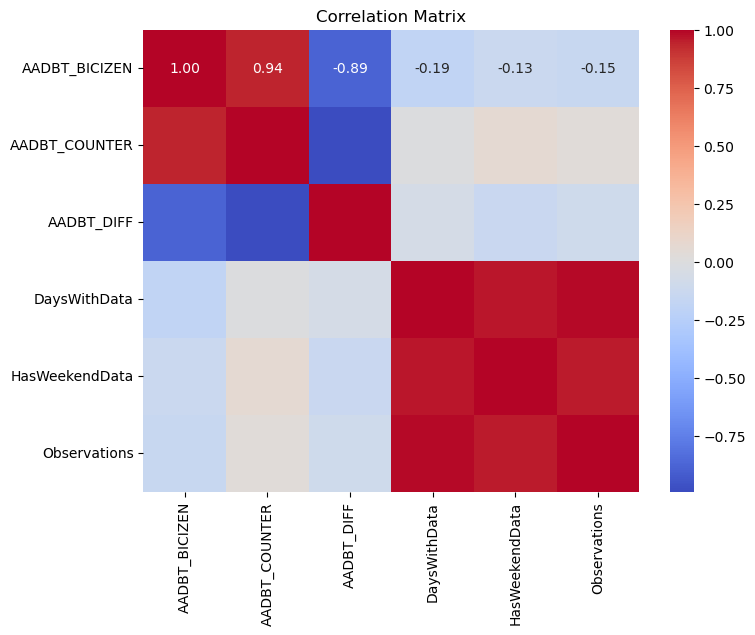

In [628]:
# Calculate the correlation matrix
correlation_matrix = final_df[['AADBT_BICIZEN', 'AADBT_COUNTER', 'AADBT_DIFF','DaysWithData', 'HasWeekendData', 'Observations']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

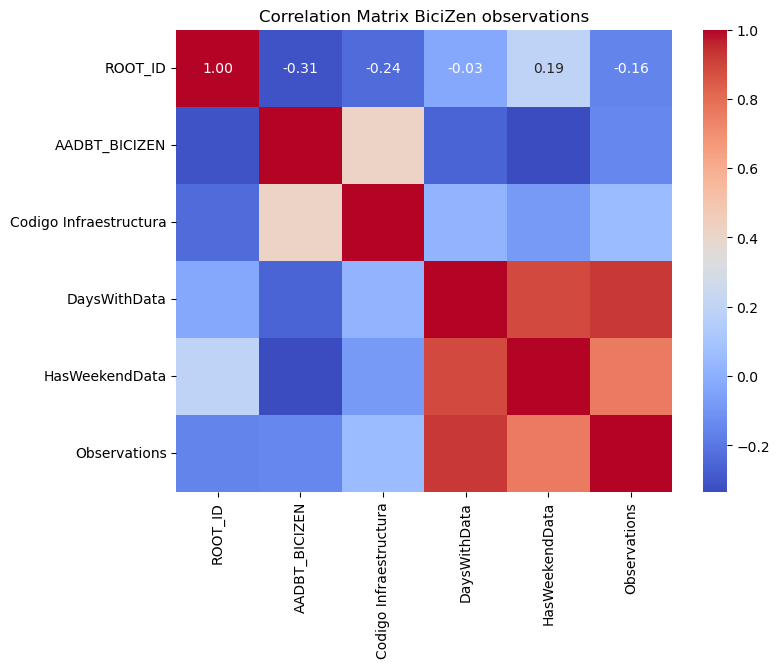

In [629]:
# Calculate the correlation matrix for numeric attributes in merged_df
correlation_numeric = merged_df.select_dtypes(include=['float64', 'int64','bool']).corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_numeric, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix BiciZen observations')
plt.show()

## Ger problematic values

In [630]:
final_df=final_df[['ROOT_ID', 'AADBT_DIFF',  'AADBT_BICIZEN', 'AADBT_COUNTER', 'Street',
       'direction_counter', 'Codigo Infraestructura', 'DaysWithData',
       'HasWeekendData', 'Observations', 'geometry',  'Locations']]
final_df.sort_values(by="AADBT_DIFF").head(16)

,ROOT_ID,AADBT_DIFF,AADBT_BICIZEN,AADBT_COUNTER,Street,direction_counter,Codigo Infraestructura,DaysWithData,HasWeekendData,Observations,geometry,Locations
2,1047953,-4553.031727,2371.968273,6925.0,Pg. Pujades 3,SW,5,10,False,12,POINT (431650.609 4582239.199),Pg. Pujades 3 SW
8,1049380,-3818.719749,1674.280251,5493.0,Travessera de gràcia 260,SW,7,31,True,40,POINT (430235.035 4584150.178),Travessera de gràcia 260 SW
6,1048274,-3427.452814,1342.547186,4770.0,Travessera de gràcia 260,NE,7,31,True,43,POINT (430235.035 4584150.178),Travessera de gràcia 260 NE
3,1048223,-3376.739935,1521.260065,4898.0,Av. Meridiana 82,N,7,11,False,13,POINT (432061.273 4584212.752),Av. Meridiana 82 N
5,1048272,-1421.680507,504.319493,1926.0,Aristides Maillol 3106,N,7,13,False,13,POINT (426382.214 4581269.343),Aristides Maillol 3106 N
9,1051865,-978.920142,556.079858,1535.0,Ronda Guinardó 111,NE,7,27,True,34,POINT (430852.232 4585230.121),Ronda Guinardó 111 NE
4,1048268,-749.251828,385.748172,1135.0,Ronda Guinardó 111,SW,7,33,True,42,POINT (430852.232 4585230.121),Ronda Guinardó 111 SW
7,1048280,-615.654291,826.345709,1442.0,Av. Maria Cristina - Palau de Congressos,SE,5,17,False,23,POINT (429003.890 4580413.799),Av. Maria Cristina - Palau de Congressos SE
1,1046328,-449.380092,644.619908,1094.0,Via Augusta 360,NW,7,10,False,13,POINT (426616.254 4583734.058),Via Augusta 360 NW
10,1054514,-403.872568,1014.127432,1418.0,Aristides Maillol 3106,S,7,13,False,13,POINT (426382.214 4581269.343),Aristides Maillol 3106 S


# Save output